<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/NELL2/Optimize_Masking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats
import javabridge
import bioformats
javabridge.start_vm(class_path=bioformats.JARS)

####
from IPython.display import clear_output

import numpy as np
import pandas as pd
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
import os
import scipy
from scipy import ndimage as ndi
import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

!pip install cellpose
from cellpose import models
clear_output()

In [2]:
def get_drobox_folder(link, new_filename):
    'Download a folder from dropbox and unzip'
    zipped_file_path = "/content/"+new_filename + ".zip"
    unzipped_file_path = "/content/"+new_filename
    if not( os.path.exists(zipped_file_path)):
        !wget -O $zipped_file_path $link    # download with new name
    !echo A | unzip $zipped_file_path -d $unzipped_file_path 
    return new_filename

def get_sub_files(rootdir):
    'Recursively search subfolders and return a list of all files'
    file_list =[]
    for rootdir, dirs, files in os.walk(rootdir): 
            file_list.extend([os.path.join(rootdir,f) for f in files])
    return file_list

In [27]:




def read_image(image_name):
    my_reader = bioformats.get_image_reader('my_image', image_name)

    c_dim = my_reader.rdr.getSizeC()
    z_dim = my_reader.rdr.getSizeZ()
    x_dim = my_reader.rdr.getSizeX()
    y_dim = my_reader.rdr.getSizeY()
    # print(x_dim,y_dim,c_dim,z_dim)

    image = np.empty([x_dim,y_dim,c_dim,z_dim])
    for zi in range(z_dim):
        img_zi = my_reader.read(c=None, z=zi,rescale=True)
        image[:,:,:,zi] = img_zi

    for ci in range(image.shape[2]):
        cim = image[:,:,ci,:]
        flat = cim.flatten()
        max= np.percentile(flat,100)
        assert max>0 , print(flat)
        cim = cim/max
        image[:,:,ci,:] = cim
    return image




def norm_channels(image,chan_dim,z_dim,):
    '''Transpose ndims, preserve labels'''
    dim_order = np.arange(image.ndim).tolist()
    dim_order = [chan_dim, z_dim] + [d for d in dim_order if d not in [chan_dim, z_dim]]
    chan_dim = [i for i in range(len(dim_order)) if dim_order[i]==chan_dim][0]
    z_dim = [i for i in range(len(dim_order)) if dim_order[i]==z_dim][0]

    '''Normalize channel intensities'''
    image_r=np.transpose(image.copy(),dim_order)
    ch_val_list = []
    for ch in range(image_r.shape[chan_dim]):    
        ch_val = image_r[ch,:,:,:].copy()
        for zi in range(image_r.shape[z_dim]):
            ch_val_z = ch_val[zi,:,:]
            ch_val_z = (ch_val_z-np.mean(ch_val_z.flatten())) / np.std(ch_val_z.flatten()) # zscore
            ch_val_z = (ch_val_z) / np.std(ch_val_z.flatten())
            ch_val[zi,:,:] = ch_val_z
        ch_val_list.append(ch_val)
    image_znorm = np.stack(ch_val_list,axis=0)
    return image_znorm, image_r,chan_dim,z_dim

def mask_image_cellpose(image_r,cell_chan,diameter,exp_dist):
    '''Generate Masks with Cellpose'''
    model = models.Cellpose(model_type='cyto')
    masks, _, _, _ = model.eval(image_r[cell_chan,:,:,:], diameter=diameter, channels=[0,0], stitch_threshold=.001,do_3D=False)
    masks=masks.astype(float)
    exp_masks = masks.copy()
    for zi in range(masks.shape[0]):
        exp_masks[zi,:,:] = skimage.segmentation.expand_labels(exp_masks[zi,:,:], distance=exp_dist)
    return masks, exp_masks


def quant_cells(image_znorm, image_r, exp_masks,chan_dim):
    '''Quantify Cell Intensities'''
    cell_ids =np.arange(0,np.nanmax(exp_masks.flatten()))+1
    cell_df = pd.DataFrame({'cell_id':cell_ids}).set_index('cell_id')
    for ch in range(image_znorm.shape[chan_dim]):
        for cell in cell_df.index:
            cell_df.at[cell,'size'] = np.nansum((exp_masks.flatten()==cell))
            cell_df.at[cell,'mean_'+ch_names[ch]] = np.nansum( image_znorm[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
            cell_df.at[cell,'raw_mean_'+ch_names[ch]] = np.nansum( image_r[ch,:,:,:][exp_masks==cell]) / cell_df.loc[cell,'size']
    
    

    return cell_df


def calc_odd(cell_df,t):
    '''Calculate Odds Ratios'''
    is_green = cell_df['mean_target']>t
    not_green = cell_df['mean_target']<=t
    is_red = cell_df['mean_mCherry']>t
    not_red = cell_df['mean_mCherry']<=t

    p_G_nR = np.mean(  is_green[not_red]  )
    p_G_iR = np.mean(  is_green[is_red]  )
    # print('P(G|~R)',p_G_nR)
    # print('P(G|R)',p_G_iR)

    p_R_iG = np.mean(  is_red[is_green]  )
    p_R_nG = np.mean(  is_red[not_green]  )
    # print('P(R|G)',p_R_iG)
    # print('P(R|~G)',p_R_nG)

    num_RnG = np.sum(is_red[not_green] )
    num_nRnG = np.sum(not_red[not_green] )
    num_RG = np.sum(is_red[is_green] )
    num_nRG = np.sum(not_red[is_green] )
    OR = (num_RG * num_nRnG)/ (num_RnG * num_nRG)
    # print('odds',OR)

    targ_sig_nR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']<t])
    targ_sig_iR = np.mean(cell_df['raw_mean_target'][cell_df['mean_mCherry']>t])

    results = {'OR':OR,
               'num_RnG':num_RnG,
               'num_nRnG':num_nRnG,
               'num_RG':num_RG,
               'num_nRG':num_nRG,
               'targ_sig_nR':targ_sig_nR,
               'targ_sig_iR':targ_sig_iR}

    cell_df['Pos']=cell_df['mean_mCherry']>t
    mean_target_negative = np.mean(cell_df['raw_mean_target'][np.logical_not(cell_df['Pos'].values)])
    cell_df['target_norm'] = cell_df['raw_mean_target'] / mean_target_negative
    cell_df['target_norm_NEG'] = cell_df['target_norm'][np.logical_not(cell_df['Pos'].values)]
    cell_df['target_norm_POS'] = cell_df['target_norm'][cell_df['Pos']]

    results=pd.DataFrame(data=results,index=[0])


    return results, cell_df



def plot_sample(fov,inset_xy=None,pxl_per_um=800/159.1,title=None,zi=0,mask=None):
    sb_x = 195
    sb_y = 4
    sb_x = 780
    sb_y = 10

    image_name= fov['image_name']
    image_name= os.path.basename(fov['image_name']).split('.')[0]
    potential_targets = ['MDGA2','Nell2','RNF182']
    target_name = [t for t in potential_targets if t in image_name][0]
    # print(target_name)

    if inset_xy is not None: fig_sample, axs = plt.subplots(2,4,figsize=(24,12))
    else: fig_sample, axs = plt.subplots(1,4,figsize=(24,6))
    
    axs=axs.flatten()
    axs[0].imshow(fov['image_znorm'][2,zi,:,:],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(fov['image_znorm'][1,zi,:,:],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(fov['image_znorm'][0,zi,:,:],cmap=cmap,vmax=2)
    w_sig = fov['image_znorm'][2,zi,:,:]
    w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
    w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
    w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
    r_sig = fov['image_znorm'][1,zi,:,:]
    r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
    r_sig = r_sig/np.percentile(r_sig.flatten(),100)
    r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
    g_sig = fov['image_znorm'][0,zi,:,:]
    g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
    g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
    g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
    gain = 2
    merge = w_chan + r_chan + g_chan
    axs[3].imshow(merge)


    axs[0].text(10,790,'NeuN',color='w',fontsize=24)
    axs[1].text(10,790,'mCherry',color=[1,0,0,1],fontsize=24)
    axs[2].text(10,790,target_name,color=[0,1,0,1],fontsize=24)
    # axs[3].text(0,800,'NeuN',color='w')

    pxl_per_um = 800/160
    sb_x = merge.shape[1]*.975
    sb_y = merge.shape[0]*.025
    big_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -25*pxl_per_um , 10, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    axs[0].add_patch(big_scale_bar)

    if inset_xy is not None:
        y1,y2,x1,x2, = inset_xy
        my_rect = matplotlib.patches.Rectangle([y1,x1],  y2-y1, x2-x1,alpha=1, facecolor='none',edgecolor='c',linewidth=3)
        axs[0].add_patch(my_rect)

        # fig, axs = plt.subplots(1,4,figsize=(32,8))
        # axs=axs.flatten()
        axs[4].imshow(fov['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
        axs[5].imshow(fov['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
        axs[6].imshow(fov['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
        axs[7].imshow(merge[x1:x2,y1:y2,:])

        sb_x = (x2-x1)*.975
        sb_y = (y2-y1)*.025
        small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
        axs[4].add_patch(small_scale_bar)


    for a in axs:
            a.get_xaxis().set_visible(False)
            a.get_yaxis().set_visible(False)
        
    if mask is not None:
        mask_bin = mask[zi,:,:]>0
        for a in axs[:4]:
            a.contour(mask_bin)
        for a in axs[4:]:
            a.contour(mask_bin[x1:x2,y1:y2])


    if title is not None:
        fig_sample.suptitle(title)
    plt.tight_layout(pad=1.1)
    plt.show()
    fig_sample.savefig(image_name+'MergePlot.png')
    
    return None



def image_pipeline(image_name,chan_dim,cell_chan,z_dim,t=0):
    try:
        image = read_image(image_name)

        if image.shape[chan_dim]==4:
            image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )

        image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
        diameter = 30
        exp_dist = 5
        masks, exp_masks = mask_image_cellpose(image_r,cell_chan,diameter,exp_dist)
        cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
        results,cell_df = calc_odd(cell_df,t)
        cur_image_name= os.path.basename(image_name).split('.')[0]
        potential_targets = ['MDGA2','Nell2','RNF182']
        target_name = [t for t in potential_targets if t in cur_image_name][0]
        cell_df.to_csv( cur_image_name+'Cell_Stats.csv')

        

        fov_dict = {'image_name':image_name,
                    'raw_image':image,
                    'image_r':image_r,
                    'image_znorm':image_znorm,
                    'masks':masks,
                    'exp_masks':exp_masks,
                    'cell_df':cell_df,
                    'results':results,
                    }

        inset_xy =  [150,350,0,200]
        plot_sample(fov_dict,inset_xy)
    except: print(image_name)
    
    return fov_dict


In [5]:


data_drop_folder = 'https://www.dropbox.com/sh/dbuo3g9pd598xmw/AABx6mF-MN7Pyhr4xZWmOfWka?dl=0' # NELL2

folder = get_drobox_folder(data_drop_folder, 'images')
file_list = get_sub_files(folder)
file_list.sort()
file_list = [f for f in file_list if 'DAPI' not in f]



# def score_image(image,chan_dim,cell_chan):
chan_dim = 2
cell_chan = 2
z_dim = 3
diameter = 30
min_vox = 500
t = 1
ch_names = ['target','mCherry','NeuN']


image_name = file_list[0]

######################
#####################

image = read_image(image_name)

if image.shape[chan_dim]==4:
    image = combine_dapi_neun( image, chan_dim, ch_ind=[0,3], keep_ch=3,scalar = 0 )


image_znorm, image_r,chan_dim,z_dim = norm_channels(image,chan_dim,z_dim,)
diameter = 40
exp_dist = 5
masks, exp_masks = mask_image_cellpose(image_r[:,:,:,:],cell_chan,diameter,exp_dist)

fov_dict = {'image_name':image_name,'raw_image':image,'image_znorm':image_znorm,'masks':masks,'exp_masks':exp_masks}

plot_sample(fov_dict,title=fov_dict['image_name'],zi=4,mask=masks) # inset_xy =  [150,350,0,200]


cell_df = quant_cells(image_znorm, image_r, exp_masks,chan_dim)
results,cell_df = calc_odd(cell_df,t)
cur_image_name= os.path.basename(image_name).split('.')[0]
potential_targets = ['MDGA2','Nell2','RNF182']
target_name = [t for t in potential_targets if t in cur_image_name][0]
cell_df.to_csv( cur_image_name+'Cell_Stats.csv')


fov_dict = {'image_name':image_name,
            'raw_image':image,
            'image_r':image_r,
            'image_znorm':image_znorm,
            'masks':masks,
            'exp_masks':exp_masks,
            'cell_df':cell_df,
            'results':results,
            }


# # daims=np.arange(10,80,10)
# # mask_dict = {}
# # for d in daims:
# #     masks, _ = mask_image_cellpose(image_r,cell_chan,diameter=d,exp_dist=0)
# #     mask_dict[d]=masks

# # print(mask_dict.keys())


# def display_cells(fov_dict,n=10):
#     # plot_sample(fov_dict,mask=fov_dict['masks'])

#     cell_df = fov_dict['cell_df']
#     pos_list = cell_df.index[cell_df['Pos']].tolist()
#     pos_list = [int(i) for i in pos_list]
#     pos_list_trunc = pos_list[:n+1]
#     print(pos_list_trunc)

#     mask = fov_dict['exp_masks']
#     cell_id=1
#     # for cell_id in pos_list_trunc:
#     wher = np.where(mask==cell_id)
#     print(np.where(mask==cell_id))
#     top_left = [np.min(wher[1]), np.min(wher[2])]
#     print(top_left)

    
# display_cells(v)

Archive:  /content/images.zip
mapname:  conversion of  failed
replace /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/images/Nell2_08-04-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-09-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-10-22_DG_40X_2XZoom_1.oir  
 extracting: /content/images/Nell2_08-04-22_CA3_40X_2XZoom_1.oir  

JavaException: ignored

In [7]:
import tifffile
mask_file_name = fov_dict['image_name'].split('.')[0].split('/')[-1] + '_mask.tiff'
print(mask_file_name)
tifffile.imsave(mask_file_name,fov_dict['masks'])



Nell2_08-04-22_CA3_40X_2XZoom_1_mask.tiff


In [45]:
def merge_rgbz(image):
    merge_list=[]
    for zi in range(image.shape[1]):
        w_sig = image[2,zi,:,:]
        w_sig = w_sig+np.percentile(w_sig.flatten(),.1)
        w_sig = w_sig/np.percentile(w_sig.flatten(),99.9)
        w_chan = np.stack( [w_sig for i in range(3)] ,axis=-1)
        r_sig = image[1,zi,:,:]
        r_sig = r_sig+np.percentile(r_sig.flatten(),.0)
        r_sig = r_sig/np.percentile(r_sig.flatten(),100)
        r_chan = np.stack( [r_sig, np.zeros_like(r_sig), np.zeros_like(r_sig)],axis=-1)
        g_sig =image[0,zi,:,:]
        g_sig = g_sig-(np.percentile(g_sig.flatten(),0)*2)
        g_sig = g_sig/(np.percentile(g_sig.flatten(),100)*1)
        g_chan = np.stack( [ np.zeros_like(g_sig), g_sig, np.zeros_like(g_sig)],axis=-1)
        gain = 2
        merge_zi = w_chan + r_chan + g_chan
        merge_list.append(merge_zi)
    merge = np.stack(merge_list)
    return merge

[3, 4, 5, 47, 73, 76, 82]
(array([0, 0, 0, ..., 0, 0, 0]), array([ 0,  0,  0, ..., 37, 37, 37]), array([544, 545, 546, ..., 578, 579, 580]))
[0, 542] [37, 613] [0]
(3, 37, 71)
0


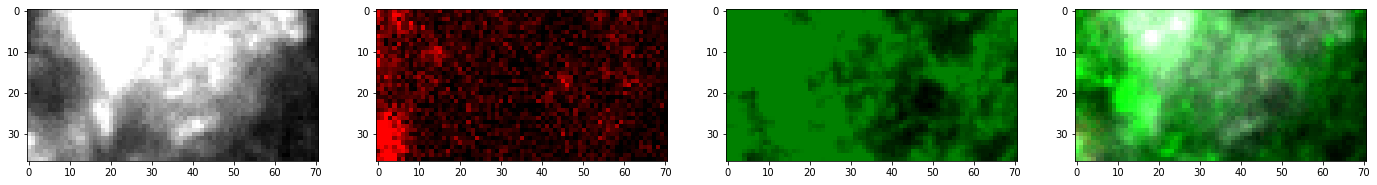

In [48]:
def display_cells(fov_dict,n=10):
    # plot_sample(fov_dict,mask=fov_dict['masks'])

    cell_df = fov_dict['cell_df']
    pos_list = cell_df.index[cell_df['Pos']].tolist()
    pos_list = [int(i) for i in pos_list]
    pos_list_trunc = pos_list[:n+1]
    print(pos_list_trunc)

    mask = fov_dict['exp_masks']
    cell_id=1
    # for cell_id in pos_list_trunc:
    wher = np.where(mask==cell_id)
    print(np.where(mask==cell_id))
    top_left = [np.min(wher[1]), np.min(wher[2])]
    bot_right = [np.max(wher[1]), np.max(wher[2])]
    zr = list(set(wher[0]))
    print(top_left,bot_right,list(set(zr)))
    x1, y1 = top_left
    x2, y2 = bot_right
    sub_im = fov_dict['image_znorm'][:,zr,x1:x2,y1:y2]
    
    sub_im_zstk = np.sum(sub_im,axis=1)
    print(sub_im_zstk.shape)

    fig, axs = plt.subplots(1,4,figsize=(24,6))
    
    zi = int(np.median(zr))
    print(zi)

    merge = merge_rgbz(fov_dict['image_znorm'])

    axs[0].imshow(fov_dict['image_znorm'][2,zi,x1:x2,y1:y2],cmap='gray',vmax=3)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","red"])
    axs[1].imshow(fov_dict['image_znorm'][1,zi,x1:x2,y1:y2],cmap=cmap, vmax=4)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black","green"])
    axs[2].imshow(fov_dict['image_znorm'][0,zi,x1:x2,y1:y2],cmap=cmap,vmax=2)
    axs[3].imshow(merge[zi,x1:x2,y1:y2,:])

    F

    sb_x = (x2-x1)*.975
    sb_y = (y2-y1)*.025
    # pxl_per_um
    # small_scale_bar = matplotlib.patches.Rectangle([sb_x,sb_y],   -5*pxl_per_um , 3, alpha=1, facecolor='w',edgecolor='w',linewidth=0)
    # axs[4].add_patch(small_scale_bar)

display_cells(fov_dict)